In [1]:
#!pip install xarray

In [2]:
from datetime import datetime
import glob
import multiprocessing
import numpy as np
import os
import xarray as xr  

## Helper Functions

In [3]:
SYS_VARS = ['dcl_controller_timestamp','driver_timestamp','provenance','ingestion_timestamp','internal_timestamp','date_time_string','port_timestamp', 'preferred_timestamp', 'id','suspect_timestamp']

def find_files(site: str, node: str, instrument: str, stream: str, begin_datetime: datetime, end_datetime: datetime, deployment: int | None = None, extension: str = 'nc') -> list:
    _USER_DIR = os.path.expanduser('~')
    DATA_DIR = os.path.join(_USER_DIR, 'ooi')
    KDATA_DIR = os.path.join(DATA_DIR, 'kdata') 

    if deployment is not None:
        _deployment = str(deployment).zfill(4)
        glob_fp = os.path.join(KDATA_DIR, f"*{site}*{node}*{instrument}*{stream}*/deployment{_deployment}*{site}*{node}*{instrument}*{stream}*{extension}")
    else:
        glob_fp = os.path.join(KDATA_DIR, f"*{site}*{node}*{instrument}*{stream}*/deployment*{site}*{node}*{instrument}*{stream}*{extension}")

    files = glob.glob(glob_fp, recursive = True)

    if len(files) == 0:
        raise FileNotFoundError(f'No files found for glob lookup {glob_fp}.')

    files = sorted(files)
    return files


def load_ooi_file(filepath: str, drop_sys_vars: bool = True, drop_qartod_executed: bool = True) -> xr.Dataset:
    _ds = xr.open_dataset(filepath)
    _ds = _ds.swap_dims({'obs': 'time'})
    _ds = _ds.drop_vars(['obs'], errors = 'ignore')

    if drop_sys_vars is True:
        _ds = _ds.drop_vars(SYS_VARS, errors = 'ignore')

    if drop_qartod_executed is True:
        _ds = _ds.drop_vars([dv for dv in list(_ds.data_vars) if 'executed' in dv], errors = 'ignore')
    return _ds

## Load CTD Data for CP10CNSM Near Surface Instrument Frame

In [4]:
site = 'CP10CNSM'
node = 'RID'
instrument = 'CTD'
stream = 'ctd*instrument'
begin_datetime = datetime(2024,5,1)
end_datetime = datetime(2024,8,31,23,59,59,999999)

ctd_files = find_files(site = site, node = node, instrument = instrument, stream = stream, 
                       begin_datetime = begin_datetime, end_datetime = end_datetime)

In [5]:
print(f'Number of CTD Files: {len(ctd_files)}')
print(ctd_files)

Number of CTD Files: 52
['/home/jovyan/ooi/kdata/CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument/deployment0001_CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument_20240403T140019.268000-20250405T120309.501000.nc', '/home/jovyan/ooi/kdata/CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument/deployment0002_CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument_20250402T130020.104000-20250429T040309.765000.nc', '/home/jovyan/ooi/kdata/CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument/deployment0002_CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument_20250429T040309.765000-20250430T050309.754000.nc', '/home/jovyan/ooi/kdata/CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument/deployment0002_CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrument_20250430T050309.754000-20250501T060309.745000.nc', '/home/jovyan/ooi/kdata/CP10CNSM-RID27-03-CTDBPC000-telemetered-ctdbp_cdef_dcl_instrume

In [6]:
with multiprocessing.Pool() as pool:
    ctd_ds_list = pool.map(load_ooi_file, ctd_files)
ctd_ds = xr.concat(ctd_ds_list, dim = 'time',combine_attrs = 'drop_conflicts')

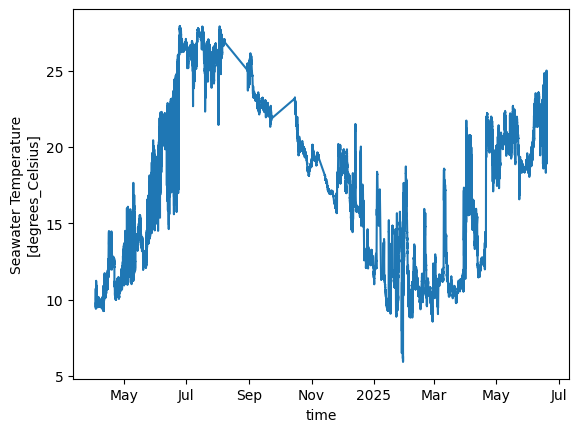

In [7]:
ctd_ds.sea_water_temperature.plot()

## Load LISST Files

In [8]:
site = 'CP10CNSM'
node = 'RID'
instrument = 'PRTSZ'
stream = 'prtsz*instrument'
begin_datetime = datetime(2024,5,1)
end_datetime = datetime(2024,8,31,23,59,59,999999)

lisst_files = find_files(site = site, node = node, instrument = instrument, stream = stream, 
                       begin_datetime = begin_datetime, end_datetime = end_datetime)

In [9]:
with multiprocessing.Pool() as pool:
    lisst_ds_list = pool.map(load_ooi_file, lisst_files)
lisst_ds = xr.concat(lisst_ds_list, dim = 'time',combine_attrs = 'drop_conflicts')

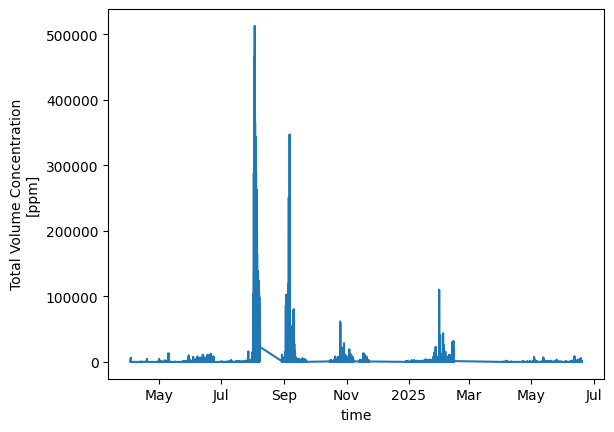

In [10]:
lisst_ds.total_volume_concentration.plot()